In [4]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path
# Util function for loading point clouds|
import numpy as np
from scipy.io import loadmat
import json
import sys
import matplotlib.image as mpimg

In [2]:
# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    PerspectiveCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

from pytorch3d.utils import cameras_from_opencv_projection

In [3]:
%matplotlib inline
# if __name__ == '__main__':
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

Do not run the following cells. Skip to section 2

In [ ]:
# # if __name__ == '__main__':
# if torch.cuda.is_available():
#     device = torch.device("cuda:0")
#     torch.cuda.set_device(device)
# else:
#     device = torch.device("cpu")

file_num = '024'
base_path_simsub = '../../../../Hierarchical-Localization/'
end_path = 'graphVPR/ideas_SG/place-graphVPR/rand_json'
json_dir = os.path.join(base_path_simsub,end_path)
p3p_num = 'p3p_{}'.format(file_num)
p3p_dir = os.path.join(json_dir, p3p_num)
p3p_files = os.listdir(p3p_dir)

# TODO1: should change this to explicitly throw error if DUC_cutout not found.
for i in p3p_files:
    if 'DUC_cutout' in i:
        break


base_mat_path = "../../../../DUC1/"
jpg_file = os.path.join(base_mat_path + file_num, i)
pc_file = jpg_file + '.mat'
json_file = p3p_num + '.json'
json_file = os.path.join(p3p_dir, json_file)

# uncomment for sanity check
print(jpg_file, os.path.isfile(jpg_file))
print(json_file, os.path.isfile(json_file))
print(pc_file, os.path.isfile(pc_file))

In [ ]:
#create point cloud
# TODO: modify/add loop for multi scans for entire room
xyz_file  = loadmat(Path(pc_file))["XYZcut"]
rgb_file = loadmat(Path(pc_file))["RGBcut"]
xyz_sp = (xyz_file.shape)
with open(json_file,'r') as f:
    json_data = json.load(f)
xyz_file = (xyz_file.reshape((xyz_sp[0]*xyz_sp[1] ,3)))
rgb_file = (rgb_file.reshape((xyz_sp[0]*xyz_sp[1] ,3)))
verts = torch.Tensor(xyz_file).to(device)
rgb = torch.Tensor(rgb_file).to(device)
point_cloud = Pointclouds(points=[verts], features=[rgb])

In [ ]:
RT_np = np.array(json_data['extrinsic'])
K_np = np.array(json_data['intrinsic']['intrinsic_matrix'])
RT_np = RT_np.reshape(4,4).T
K = K_np.reshape(3,3).T
# print(RT_np)
# print(K)

fx, fy = K[0,0], K[1,1] # focal length in x and y axes
px, py = K[0,2], K[1,2] # principal points in x and y axes
R, t =  RT_np[0:3,0:3], np.array([RT_np[0:3,3]]) #  rotation and translation matrix

# # First, (X, Y, Z) = R @ p_world + t, where p_world is 3D coordinte under world system
# # To go from a coordinate under view system (X, Y, Z) to screen space, the perspective camera mode should consider
# # the following transformation and we can get coordinates in screen space in the range of [0, W-1] and [0, H-1]
# x_screen = fx * X / Z + px
# y_screen = fy * Y / Z + py

# In PyTorch3D, we need to build the input first in order to define camera. Note that we consider batch size N = 1
RR = torch.from_numpy(R).unsqueeze(0) # dim = (1, 3, 3)
KK = torch.from_numpy(K).unsqueeze(0) # dim = (1, 3, 3)
# following line transposes matrix
# RR = torch.from_numpy(R).permute(1,0).unsqueeze(0) # dim = (1, 3, 3) 
tt = torch.from_numpy(t) # dim = (1, 3)
f = torch.tensor((fx, fy), dtype=torch.float32).unsqueeze(0) # dim = (1, 2)
p = torch.tensor((px, py), dtype=torch.float32).unsqueeze(0) # dim = (1, 2)
img_size = (1600, 1200)
img_size_t = torch.tensor(img_size).unsqueeze(0) # (width, height) of the image
# img_size_t = torch.tensor(img_size, dtype=torch.float32).unsqueeze(0) # (width, height) of the image
# KK.shape

In [ ]:
cameras_pytorch3d = cameras_from_opencv_projection(RR.float(), tt.float(), KK.float(), img_size_t.float())
# above line was giving dtype errors, so made everything float..
cameras_pytorch3d  = cameras_pytorch3d.to(device)
# (img_size_t.float().dtype, RR.dtype)

In [ ]:
# Now, we can define the Perspective Camera model. 
# NOTE: you should consider negative focal length as input!!!
cameras = PerspectiveCameras(R=RR, T=tt, focal_length=-f, principal_point=p,
    device=device,image_size=(img_size,))
# cameras

In [ ]:

# print(cameras.K)
# unsure about radius and points_per_pixel
raster_settings = PointsRasterizationSettings(
    image_size=[1200,1600], 
    radius = 0.003,
    points_per_pixel = 20
)
# You can modify AlphaCompositor
# to change background color
rasterizer = PointsRasterizer(cameras=cameras_pytorch3d, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)
print("till here")
images = renderer(point_cloud)
#We need to convert 
images_np = images[0, ..., :3].cpu().numpy()
images_np[images_np < 0] = 0
images_np = images_np.astype(np.uint8)
# plt.imsave(file_num + '_pytorchsyn.png',images_np)
# print(f"{file_num}_pytorchsyn.png saved")

In [ ]:
%matplotlib inline

In [ ]:
plt.imshow(images_np)
plt.show()

---
## Section 2: Re-ordering the above code to fit into one function

### args to experiment with:

Directory structure should be like this: 
```bash
├── DUC1
├── Hierarchical-Localization
└── pytorch3d
```

This notebook is located in pytorch3d sub folder
<ol>
  <li>NUM(which image)</li>
  <li>Radius</li>
  <li>number of pixels per point(TODO: understand this)</li>
</ol> 

In [20]:
def plot_file(device,file_num = '024',radius_size = 0.003, points_per_pix = 20, bg_col = (0,0,0)):
    print("Displaying for num:", file_num)
    print("Radius:", radius_size)
    print("")
    base_path_simsub = '../../../../Hierarchical-Localization/'
    end_path = 'graphVPR/ideas_SG/place-graphVPR/rand_json'
    json_dir = os.path.join(base_path_simsub,end_path)
    p3p_num = 'p3p_{}'.format(file_num)
    p3p_dir = os.path.join(json_dir, p3p_num)
    p3p_files = os.listdir(p3p_dir)
    # TODO1: should change this to explicitly throw error if DUC_cutout not found.
    for i in p3p_files:
        if 'synth-single' in i or 'jsonsynth' in i:
            synth_image = i
        if 'DUC_cutout' in i:
            jpg_file = i
    # 
    # 
    base_mat_path = "../../../../DUC1/"
    jpg_file = os.path.join(base_mat_path + file_num, jpg_file)
    pc_file = jpg_file + '.mat'
    json_file = p3p_num + '.json'
    json_file = os.path.join(p3p_dir, json_file)
    synth_file = os.path.join(p3p_dir, synth_image)
    xyz_file  = loadmat(Path(pc_file))["XYZcut"]
    rgb_file = loadmat(Path(pc_file))["RGBcut"]
    xyz_sp = (xyz_file.shape)
    with open(json_file,'r') as f:
        json_data = json.load(f)
    xyz_file = (xyz_file.reshape((xyz_sp[0]*xyz_sp[1] ,3)))
    rgb_file = (rgb_file.reshape((xyz_sp[0]*xyz_sp[1] ,3)))
    verts = torch.Tensor(xyz_file).to(device)
    rgb = torch.Tensor(rgb_file).to(device)
    point_cloud = Pointclouds(points=[verts], features=[rgb])
    #
    RT_np = np.array(json_data['extrinsic'])
    K_np = np.array(json_data['intrinsic']['intrinsic_matrix'])
    RT_np = RT_np.reshape(4,4).T
    K = K_np.reshape(3,3).T
    # print(RT_np)
    # print(K)
    #
    fx, fy = K[0,0], K[1,1] # focal length in x and y axes
    px, py = K[0,2], K[1,2] # principal points in x and y axes
    R, t =  RT_np[0:3,0:3], np.array([RT_np[0:3,3]]) #  rotation and translation matrix
    # # First, (X, Y, Z) = R @ p_world + t, where p_world is 3D coordinte under world system
    # # To go from a coordinate under view system (X, Y, Z) to screen space, the perspective camera mode should consider
    # # the following transformation and we can get coordinates in screen space in the range of [0, W-1] and [0, H-1]
    # x_screen = fx * X / Z + px
    # y_screen = fy * Y / Z + py
    # In PyTorch3D, we need to build the input first in order to define camera. Note that we consider batch size N = 1
    RR = torch.from_numpy(R).unsqueeze(0) # dim = (1, 3, 3)
    KK = torch.from_numpy(K).unsqueeze(0) # dim = (1, 3, 3)
    # following line transposes matrix
    # RR = torch.from_numpy(R).permute(1,0).unsqueeze(0) # dim = (1, 3, 3) 
    tt = torch.from_numpy(t) # dim = (1, 3)
    f = torch.tensor((fx, fy), dtype=torch.float32).unsqueeze(0) # dim = (1, 2)
    p = torch.tensor((px, py), dtype=torch.float32).unsqueeze(0) # dim = (1, 2)
    img_size = (1600, 1200)
    img_size_t = torch.tensor(img_size).unsqueeze(0) # (width, height) of the image
    # img_size_t = torch.tensor(img_size, dtype=torch.float32).unsqueeze(0) # (width, height) of the image
    # KK.shape
    cameras_pytorch3d = cameras_from_opencv_projection(RR.float(), tt.float(), KK.float(), img_size_t.float())
    # above line was giving dtype errors, so made everything float..
    cameras_pytorch3d.to(device)
    #
    cameras = PerspectiveCameras(R=RR, T=tt, focal_length=-f, principal_point=p,
    device=device,image_size=(img_size,))
    # (img_size_t.float().dtype, RR.dtype)
    # print(cameras.K)
    # unsure about radius and points_per_pixel
    raster_settings = PointsRasterizationSettings(
        image_size=[1200,1600], 
        radius = radius_size,
        points_per_pixel = points_per_pix
    )
    # You can modify AlphaCompositor
    # to change background color
    rasterizer = PointsRasterizer(cameras=cameras_pytorch3d, raster_settings=raster_settings)
    renderer = PointsRenderer(
    rasterizer=rasterizer,
    # Pass in background_color to the alpha compositor, setting the background color 
    # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case blue
    compositor=AlphaCompositor(background_color=bg_col)
    )
    # renderer = PointsRenderer(
    #    rasterizer=rasterizer,
    #    compositor=AlphaCompositor()
    # )
#     print("till here")
    images = renderer(point_cloud)
    #We need to convert 
    images_np = images[0, ..., :3].cpu().numpy()
    images_np[images_np < 0] = 0
    images_np = images_np.astype(np.uint8)
    # plt.imsave(file_num + '_pytorchsyn.png',images_np)
    # print(f"{file_num}_pytorchsyn.png saved")
    img = mpimg.imread(synth_file)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img)
    ax2.imshow(images_np)
    plt.show()

In [22]:
scenes = ["005", "010", "024", "025","084"]

Displaying for num: 005
Radius: 0.003



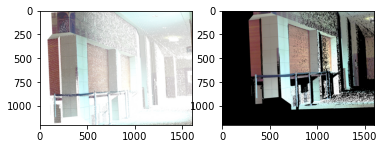

Displaying for num: 010
Radius: 0.003



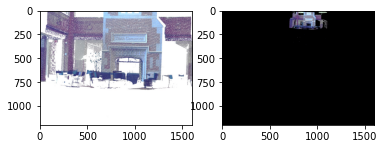

Displaying for num: 024
Radius: 0.003



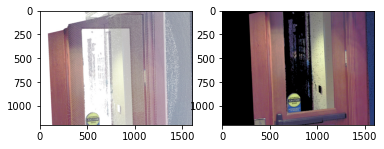

Displaying for num: 084
Radius: 0.003



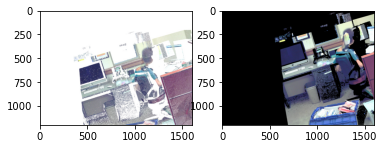

In [21]:
for scene in scenes:
    plot_file(device, file_num=scene)